<a href="https://colab.research.google.com/github/alelovato/EIC_School/blob/main/HO_NQS_determinant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Harmonic Oscillator

Here we compute the ground-state of the $ndim$-dimensional quantum harmonic oscillator for a system of $npart$ particles. The Hamiltonian of the system reads:

$$ H = -\frac{1}{2m} \sum_{i=1}^{npart} \vec{\nabla}_i^2 + \frac{m \omega^2}{2}\sum_{i=1}^{npart} \vec{x}_i^2 $$

For simplicity, we take $m=1$ and $\omega=1$. According to the variational principle of quantum mechanics, for any bosonic variational wave function $|\psi_V\rangle$,

$$ \frac{\langle \psi_V | H | \psi_V \rangle}{\langle \psi_V | \psi_V \rangle} ~ \ge ~ E_0 = \frac{1}{2} ndim * npart $$

In this notebook, we solve both a system of bosons and a system of fermions. The boson ansatz reads:

$$ \langle R | \psi_V \rangle = \psi_V(R) = \exp \left[\sum_i \mathcal{U}(\vec{r}_i)\right]$$

Note that the ground state corresponds to

$$ \psi_0(R) = \exp \left(-\frac{1}{2}\sum_i \vec{r}_i^2\right) $$


In [1]:
# Load the libraries that we need for this notebook
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, clear_output

import jax
import jaxlib
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, grad, jit, vmap, pmap, jacfwd, jacrev
from jax.example_libraries import stax
from jax.lax import fori_loop
from functools import partial

from jax.example_libraries.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, Gelu, LogSoftmax, Softplus, Tanh,
                                   Sigmoid, elementwise, FanOut, FanInConcat)
from jax.nn.initializers import glorot_normal, normal, ones, zeros

from jax.tree_util import tree_flatten
from jax.flatten_util import ravel_pytree
from jax.scipy.linalg import cho_factor, cho_solve

### WavefunctionBoson class

This class defines a variational bosonic wave function for `npart` particles in `ndim` dimensions.
It uses two dense neural networks with `Tanh` activation to model the amplitude and phase
of the log wave function separately. The `build` method initializes the networks and returns
their parameters in both structured and flattened forms.

The method `logpsi` evaluates the complex-valued log wave function by summing network outputs
over all particles and adding a confining quadratic term. `vmap_logpsi` applies `logpsi` to
a batch of configurations. Utility methods are included to flatten/unflatten parameters
and support optimizer updates.

This ansatz is symmetric under particle exchange and therefore suitable for bosonic systems.

In [2]:
class WavefunctionBoson(object):
    """Create a wave function in ndim dimensions and for npart
    bosons using a dense complex feed-forward neural net as
    a building block
    """
    def __init__(self, ndim : int, npart : int):
        self.ndim = ndim
        self.npart = npart
        self.activation = Tanh
        self.ndense = 16

    def build(self, key):
        in_shape = (-1, self.ndim)

        self.dense_init, self.dense_apply = stax.serial(
        Dense(self.ndense), self.activation,
        Dense(self.ndense), self.activation,
        Dense(1),
)
        key, key_input = jax.random.split(key)
        _, amplitude_params = self.dense_init(key_input, in_shape)

        key, key_input = jax.random.split(key)
        _, phase_params = self.dense_init(key_input, in_shape)

        net_params = [amplitude_params] + [phase_params]

        net_params = jax.tree_util.tree_map(self.update_cast, net_params)
        flat_net_params = self.flatten_params(net_params)
        num_flat_params = flat_net_params.shape[0]

        return net_params, num_flat_params

    @partial(jit, static_argnums=(0,))
    def logpsi(self, params, r):

        amplitude_params, phase_params = params
        amplitude = self.dense_apply(amplitude_params, r)
        phase = self.dense_apply(phase_params, r)

        logpsi = amplitude + 1j * jnp.pi * phase
        logpsi = jnp.sum(logpsi, axis = 0) # Here I am summing over the particles; only valid for bosons
        logpsi = jnp.reshape(logpsi, ())
        logpsi = logpsi - 0.04 * jnp.sum(r**2)
        return logpsi

    @partial(jit, static_argnums=(0,))
    def vmap_logpsi(self, params, r):
        vmap_logpsi = vmap(self.logpsi, in_axes=(None, 0))(params, r)
        return vmap_logpsi

    @partial(jit, static_argnums=(0,))
    def flatten_params(self, parameters):
        flatten_parameters, self.unravel = ravel_pytree(parameters)
        return flatten_parameters

    @partial(jit, static_argnums=(0,))
    def unflatten_params(self, flatten_parameters):
        unflatten_parameters = self.unravel(flatten_parameters)
        return unflatten_parameters

    @partial(jit, static_argnums=(0,))
    def update_add(self, params, dparams):
        return params + dparams

    @partial(jit, static_argnums=(0,))
    def update_cast(self, params):
        return params.astype(jnp.float64)

### WavefunctionFermion class

This class defines a variational wave function for `npart` fermions in `ndim` spatial dimensions.
It uses two dense feed-forward neural networks (with `Tanh` activation and width 16) to model
the amplitude and phase of `npart` single-particle orbitals. The outputs are combined into
a complex-valued matrix whose determinant defines the antisymmetric wave function.

The `logpsi` method computes the complex logarithm of the wave function using
`jnp.linalg.slogdet`, which returns both the log-determinant and the phase.
This ensures the wave function satisfies fermionic antisymmetry.

A weak harmonic term `-0.04 * sum(r**2)` is added to the log-amplitude to confine
the Markov chain configurations at the beginning of the optimization.


In [3]:
class WavefunctionFermion(object):
    """Create a wave function in ndim dimensions and for npart
    fermions using a dense complex feed-forward neural net as
    a building block
    """
    def __init__(self, ndim : int, npart : int):
        self.ndim = ndim
        self.npart = npart
        self.activation = Tanh
        self.ndense = 16

    def build(self, key):
        in_shape = (-1, self.ndim)

        self.dense_init, self.dense_apply = stax.serial(
        Dense(self.ndense), self.activation,
        Dense(self.ndense), self.activation,
        Dense(self.npart),
)
        key, key_input = jax.random.split(key)
        _, amplitude_params = self.dense_init(key_input, in_shape)

        key, key_input = jax.random.split(key)
        _, phase_params = self.dense_init(key_input, in_shape)

        net_params = [amplitude_params] + [phase_params]

        net_params = jax.tree_util.tree_map(self.update_cast, net_params)
        flat_net_params = self.flatten_params(net_params)
        num_flat_params = flat_net_params.shape[0]

        return net_params, num_flat_params

    @partial(jit, static_argnums=(0,))
    def logpsi(self, params, r):

        amplitude_params, phase_params = params
        amplitude = self.dense_apply(amplitude_params, r)
        phase = self.dense_apply(phase_params, r)

        phi = jnp.exp( amplitude + 1j * jnp.pi * phase )

        phase, logpsi = jnp.linalg.slogdet(phi)
        phase = jnp.imag(jnp.log(phase))

        logpsi = logpsi - 0.04 * jnp.sum(r**2)

        return logpsi + 1j * phase

    @partial(jit, static_argnums=(0,))
    def vmap_logpsi(self, params, r):
        vmap_logpsi = vmap(self.logpsi, in_axes=(None, 0))(params, r)
        return vmap_logpsi

    @partial(jit, static_argnums=(0,))
    def flatten_params(self, parameters):
        flatten_parameters, self.unravel = ravel_pytree(parameters)
        return flatten_parameters

    @partial(jit, static_argnums=(0,))
    def unflatten_params(self, flatten_parameters):
        unflatten_parameters = self.unravel(flatten_parameters)
        return unflatten_parameters

    @partial(jit, static_argnums=(0,))
    def update_add(self, params, dparams):
        return params + dparams

    @partial(jit, static_argnums=(0,))
    def update_cast(self, params):
        return params.astype(jnp.float64)

### Hamiltonian class

This class computes the kinetic and potential energy expectation values for a system of
`npart` particles in `ndim` dimensions, each subject to an independent harmonic oscillator potential.

- The `potential` method implements the analytic form of the harmonic potential energy,  
  $V = \frac{1}{2} \sum_i \mathbf{r}_i^2$, evaluated over batches of configurations.

- The `kinetic` method uses automatic differentiation to compute the Laplacian of the
  log wave function. It separately evaluates the real and imaginary parts via
  `jax.grad` and `jax.hessian`, and combines them to compute the kinetic energy via  

  $$
  T = -\frac{1}{2} \left( \nabla^2 \log \psi + |\nabla \log \psi|^2 \right).
  $$

- The `energy` method returns the kinetic, potential, and total energy for a given
  batch of configurations, using `vmap` for efficient evaluation.

The class is designed to work with any wave function object that implements a `.logpsi(params, r)` method.


In [4]:
class Hamiltonian(object):
    """Expectation values of the kinetic and potential energies of
       a collection of independent harmonic oscillators.
    """
    def __init__(self, ndim : int, npart : int, wavefunction : callable):
       self.ndim = ndim
       self.npart = npart
       self.wavefunction = wavefunction

    @partial(jit, static_argnums=(0,))
    def potential (self, x):
        """ The HO oscillator potential is given by
        V = <x|V|psi> / <x|psi> = 1/2 sum_i x_i^2
        """
        pe = 0.5 * jnp.sum(x**2, axis=(1,2))
        return pe

    @partial(jit, static_argnums=(0,))
    def kinetic(self, params, r):
        """ Use autodiff to compute the kinetic energy
        """
        logpsi_r = lambda r: jnp.real(self.wavefunction.logpsi(params, r))
        logpsi_i = lambda r: jnp.imag(self.wavefunction.logpsi(params, r))

        d_logpsi_r = jax.grad(logpsi_r)(r)
        d2_logpsi_r = jax.hessian(logpsi_r)(r)
        d2_logpsi_r = jnp.reshape(d2_logpsi_r, (self.ndim * self.npart, self.ndim * self.npart))

        d_logpsi_i = jax.grad(logpsi_i)(r)
        d2_logpsi_i = jax.hessian(logpsi_i)(r)
        d2_logpsi_i = jnp.reshape(d2_logpsi_i, (self.ndim * self.npart, self.ndim * self.npart))

        d_logpsi = d_logpsi_r + 1j * d_logpsi_i
        d2_logpsi = d2_logpsi_r + 1j * d2_logpsi_i
        ke = - 0.5 * ( jnp.trace(d2_logpsi) + jnp.sum( d_logpsi * d_logpsi ) )
        return ke


    @partial(jit, static_argnums=(0,))
    def energy (self, params, r):
        """ Sum of the kinetic and the potential energy """
        ke = vmap(self.kinetic, in_axes=(None, 0))(params, r)
        pe = self.potential(r)
        en = ke + pe
        return ke, pe, en

### Metropolis class

This class implements the Metropolis algorithm to sample particle configurations from a
given variational wave function in `ndim` dimensions for `npart` particles, using `nwalk`
independent walkers.

- `__init__` sets up all parameters, including the wave function, step sizes (`sig`, `sig_i`),
  number of equilibration steps (`neq`), averaging steps (`nav`), and Metropolis steps per move (`nvoid`).

- The `step` method performs `nvoid` Metropolis updates. New configurations are proposed
  using Gaussian displacements, and accepted with probability  
  $$
  A(R\to R^\prime) = \min\left(1, \left| \frac{\Psi(\mathbf{R}')}{\Psi(\mathbf{R})} \right|^2 \right).
  $$  
  Log-amplitudes of the wave function are used for numerical stability.

- The `walk` method initializes walker positions from a normal distribution with width `sig_i`,
  performs `neq` equilibration blocks (discarded), then `nav` sampling blocks, each consisting
  of `nvoid` steps. It returns the full trajectory and acceptance probabilities.

This sampler is compatible with any wave function class implementing `.vmap_logpsi(params, r)`.


In [5]:
class Metropolis(object):
    """Metropolis Sampler in N dimension

    Sample from N-D coordinates, using some initial probability distribution

    """
    def __init__(self,
          nwalk : int,
          npart : int,
          ndim : int,
          neq : int,
          nav : int,
          nvoid : int,
          sig : float,
          sig_i : float,
          wavefunction : callable):

          self.nwalk = nwalk
          self.npart = npart
          self.ndim = ndim
          self.neq = neq
          self.nav = nav
          self.nvoid = nvoid
          self.sig = sig
          self.sig_i = sig_i
          self.wavefunction = wavefunction

# Function that performs nvoid Metropolis steps
    @partial(jit, static_argnums=(0,))
    def step(self, params, x_o, key_o):

        def single_step(i, loop_carry):
            x_o, key_o, acc_o = loop_carry
            log_wpsi_o = self.wavefunction.vmap_logpsi(params, x_o)
            key_o, key_input = jax.random.split(key_o)
            x_n = x_o + self.sig * jax.random.normal(key_input, shape=[self.nwalk, self.npart, self.ndim])
            log_wpsi_n = self.wavefunction.vmap_logpsi(params, x_n)
            prob = jnp.abs(jnp.exp( 2 * ( log_wpsi_n - log_wpsi_o ) ))
            key_o, key_input = jax.random.split(key_o)
            accept = jnp.greater(prob, jax.random.uniform(key_input, shape=[self.nwalk]))
            x_o = jnp.where(accept.reshape([self.nwalk,1,1]), x_n, x_o)
            acc_o = accept.astype('float64')
            return x_o, key_o, acc_o

        acc_o = jnp.zeros(self.nwalk)
        x_o, key_o, acc_o = fori_loop(0, self.nvoid, single_step, (x_o, key_o, acc_o) )
        return x_o, acc_o, key_o

# Function that perform the full Metropolis walk and returns the path and the acceptance
    def walk(self, params, key):
        key_o, key_input = jax.random.split(key)
        x_o = self.sig_i * jax.random.normal(key_input, shape=[self.nwalk, self.npart, self.ndim])
        for i in range (neq):
            x_o, acc_o, key_o = self.step(params, x_o, key_o)
        x_s = []
        acc_s = []
        for i in range (self.nav):
            x_o, acc_o, key_o = self.step(params, x_o, key_o)
            x_s.append(x_o)
            acc_s.append(acc_o)
        x_s = jnp.concatenate(x_s)
        acc_s = jnp.concatenate(acc_s)
        return x_s, acc_s

### `estimator` function

This function computes the average and standard error of a given observable over a batch of samples.

- `observable`: a 1D array of values (e.g., energy or acceptance rates) evaluated over different configurations.
- `average`: the sample mean.
- `average_2`: the mean of the squared values.
- `error`: the standard error of the mean, computed as  
  $$
  \sigma = \frac{\sqrt{\langle O^2 \rangle - \langle O \rangle^2}}{\sqrt{N - 1}},
  $$  
  where $N$ is the number of samples.


In [6]:
# Define the function that computes the average and the standard deviation of each observables
@jit
def estimator(observable):
    average = jnp.mean(observable)
    average_2 = jnp.mean(observable**2)
    error = jnp.sqrt(average_2 - average**2) / jnp.sqrt(observable.shape[0]-1)
    return average, error

### Optimizer class

This class implements various optimization algorithms to update the parameters of a variational
wave function based on the gradient of the energy. It supports Stochastic Gradient Descent (SGD),
Adam, and Stochastic Reconfiguration (SR) with Cholesky decomposition.

- `getder` and `vmap_getder` compute the gradient of the real and imaginary parts of the log
  wave function with respect to the parameters, flattened for optimization.

- `gradient` computes the energy gradient using the estimator  
  $$
  f_i = 2 \left( \langle E_L O_i \rangle - \langle E_L \rangle \langle O_i \rangle \right),
  $$
  where $O_i$ is the derivative of the log wave function.

- `sgd` applies a simple gradient descent step: $\Delta p_i = f_i$.

- `adam` implements the Adam optimizer using exponential moving averages for the first and second
  moments of the gradient, with bias correction.

- `sr_cholesky` performs a Stochastic Reconfiguration (SR) update by solving  
  $$
  S \cdot \Delta p = f
  $$
  via Cholesky factorization, where $S$ is the covariance matrix of the centered log-derivatives:
  $$
  S_{ij} = \frac{1}{N} \sum_{n=1}^N \bar{O}_i^*(x_n) \bar{O}_j(x_n) + \epsilon \, \delta_{ij} (1 + \sqrt{g_{ii}}),
  $$
  with $\bar{O}_i(x_n) = O_i(x_n) - \langle O_i \rangle$, $N$ the number of samples, and $g_{ii}$ the adaptive second-moment estimate
  used for regularization.

The optimizer maintains internal state variables (`m_i`, `g2_i`) for momentum and adaptive learning
rate control in Adam and SR.



In [7]:
class Optimizer(object):
    """Class that computes the energy derivative
    f_i = 2[< E_L O_i > - 2 < E_L > < O_i >]
    and updates the parameters according to the SGD algorithm
    """
    def __init__(self, ndim : int, npart : int, nparams : int, wavefunction : callable):
        self.ndim = ndim
        self.npart = npart
        self.nparams = nparams
        self.wavefunction = wavefunction
        self.alpha = 0.9
        self.beta = 0.99
        self.g2_i = jnp.zeros(self.nparams)
        self.m_i = jnp.zeros(self.nparams)

    @partial(jit, static_argnums=(0,))
    def getder(self, params, x):
        logpsi_r = lambda params: jnp.real(self.wavefunction.logpsi(params, x))
        logpsi_i = lambda params: jnp.imag(self.wavefunction.logpsi(params, x))
        dlogpsi_r = self.wavefunction.flatten_params(jax.grad(logpsi_r)(params))
        dlogpsi_i = self.wavefunction.flatten_params(jax.grad(logpsi_i)(params))
        dlogpsi = dlogpsi_r + 1j * dlogpsi_i
        return dlogpsi

    @partial(jit, static_argnums=(0,))
    def vmap_getder(self, params, x):
        return vmap(self.getder, in_axes=(None, 0))(params, x)

# Computes the gradient of the energy f_i = 2[ < E_L O_i > - 2 < E_L > < O_i > ]
    @partial(jit, static_argnums=(0,))
    def gradient (self, params, x, en):
        nsamples = en.shape[0]
        jac = self.vmap_getder(params, x)
        jac = jac - jnp.mean(jac, axis=0)
        jac_conjugate = jnp.conjugate(jac)
        en = en - jnp.mean(en)
        grad_energy = jnp.real(2 * jnp.matmul(en, jac_conjugate) / nsamples)
        return grad_energy, jac

    @partial(jit, static_argnums=(0,))
    def sgd(self, params, grad_energy):
        """Parameters' update according to the SGD algorithm
      Args:
      params: initial variational parameters
      r: array with shape (n_devices, nwalk * nav, npart, ndim)
      sz: array with shape (n_devices, nwalk * nav, npart, 2)
      energy: array with shape (n_devices, nwalk * nav)

      Returns:
      dp_i: array with the same shape as ``params`` representing the best parameters' update (nparams)
      """
        f_i = grad_energy
        dp_i = f_i
        return dp_i

    @partial(jit, static_argnums=(0,))
    def adam(self, itr, params, grad_energy, g2_i, m_i):
        """Parameters' update according to the Adam algorithm
      Args:
      params: initial variational parameters
      r: array with shape (n_devices, nwalk * nav, npart, ndim)
      sz: array with shape (n_devices, nwalk * nav, npart, 2)
      energy: array with shape (n_devices, nwalk * nav)
      m_i: accumulated momentum  (nparams)
      g2_i: accumulated second order derivative squared  (nparams)
      itr : iteration

      Returns:
      dp_i: array with the same shape as ``params`` representing the best parameters' update (nparams)
      g2_i: updated accumulated second order derivative squared (nparams)
      m_i: updated accumulated momentum (nparams)
      """

        f_i = grad_energy
        m_i = self.alpha * m_i + (1. - self.alpha) * f_i
        mh_i = m_i / ( 1. - self.alpha**itr )
        g2_i = self.beta * g2_i + (1. - self.beta) * f_i**2
        g2h_i = g2_i / ( 1. - self.beta**itr )
        dp_i = mh_i / ( jnp.sqrt(g2h_i) + 0.00001 )
        return dp_i, g2_i, m_i

    @partial(jit, static_argnums=(0,))
    def sr_cholesky(self, itr, params, grad_i, jac_ni, nsamples, g2_i):
        """Parameters' update according to the SR algorithm with Cholesky solver
      Args:
      params: initial variational parameters
      r: array with shape (n_devices, nwalk * nav, npart, ndim)
      sz: array with shape (n_devices, nwalk * nav, npart, 2)
      energy: array with shape (n_devices, nwalk, nav)
      g2_i: accumulated second order derivative squared  (nparams)
      itr : iteration

      Returns:
      dp_i: array with the same shape as ``params`` representing the best parameters' update (nparams)
      g2_i: updated accumulated second order derivative squared (nparams)
      """
        eps = 0.01
        g2_i = self.beta * g2_i + (1. - self.beta) * grad_i**2
        g2h_i = g2_i / ( 1. - self.beta**itr )
        S_ij = jnp.matmul(jnp.conjugate(jnp.transpose(jac_ni)), jac_ni) / nsamples + eps * jnp.diag( 1. + jnp.sqrt(g2h_i) )
        S_ij = jnp.real(S_ij)
        U_ij, low = cho_factor(S_ij)
        dp_i = cho_solve((U_ij, low), grad_i)
        return dp_i, g2_i

In [8]:
# Set the parameters and instanciate the Wavefunction, Hamiltonian, and Metropolis classes
sig_i = 1.0         # Gaussian width for sampling the initial configuration
sig = 0.2           # Gaussian width for sampling the Metropolis Move
neq = 10            # Equilibration steps
nav = 10             # Averaging steps
nvoid = 100         # Void steps between energy calculations
nwalk = 400         # Quantum Monte Carlo configurations
ndim = 1            # Spatial dimension
npart = 2           # Number of particles
seed_walk = 19      # Seed to initialize the random-number generator of the Metropolis walk
seed_net = 17       # Seed to initialize the random-number generator of the neural network

key_net = random.PRNGKey(seed_net)
wavefunction = WavefunctionBoson(ndim, npart)
params, nparams = wavefunction.build(key_net)

hamiltonian = Hamiltonian(ndim, npart, wavefunction)
key_walk = random.PRNGKey(seed_walk)
metropolis = Metropolis(nwalk, npart, ndim, neq, nav, nvoid, sig, sig_i, wavefunction)
optimizer = Optimizer(ndim, npart, nparams, wavefunction)

### Optimization step functions

These functions define one iteration of the variational optimization using different optimization strategies:
Stochastic Gradient Descent (SGD), Adam, and Stochastic Reconfiguration (SR).

Each function follows the same general structure:
1. Run a Metropolis sampling step to generate configurations `x_s`.
2. Evaluate the kinetic, potential, and total energy on the sampled configurations.
3. Estimate the mean and statistical error of the energy using the `estimator`.
4. Compute the energy gradient with respect to the variational parameters.
5. Apply the chosen optimizer (SGD, Adam, or SR) to compute the parameter update.
6. Update and return the new parameters.

- `step_sgd`: uses plain SGD with a fixed learning rate.
- `step_adam`: uses the Adam optimizer with momentum and adaptive scaling; internal states `m_i` and `g2_i` are updated.
- `step_sr`: performs a Stochastic Reconfiguration update using the Cholesky decomposition of the covariance matrix of log-derivatives.

All steps assume that the wave function object provides `.flatten_params()` and `.unflatten_params()` methods for parameter management.


In [9]:
# Define the optimization step and perform the optimization using JAX default optimizer
learning_rate = 0.1

def step_sgd(step, key_input, params):
    x_s, acc_s = metropolis.walk(params, key_input)
    ke, pe, en =  hamiltonian.energy(params, x_s)
    energy_average, energy_error = estimator(en)
    energy_gradient, _  = optimizer.gradient(params, x_s, en)
    dp_i = optimizer.sgd(params, energy_gradient)
    params = wavefunction.flatten_params(params)
    params = params - learning_rate * dp_i
    params = wavefunction.unflatten_params(params)
    return energy_average, energy_error, params

def step_adam(itr, key_input, params):
    itr+=1
    x_s, acc_s = metropolis.walk(params, key_input)
    ke, pe, en =  hamiltonian.energy(params, x_s)
    energy_average, energy_error = estimator(en)
    energy_gradient, _ = optimizer.gradient(params, x_s, en)
    g2_i = optimizer.g2_i
    m_i = optimizer.m_i
    dp_i, optimizer.g2_i, optimizer.m_i = optimizer.adam(itr, params, energy_gradient, g2_i, m_i)
    params = wavefunction.flatten_params(params)
    params = params - learning_rate * dp_i
    params = wavefunction.unflatten_params(params)
    return energy_average, energy_error, params

def step_sr(itr, key_input, params):
    itr += 1
    x_s, acc_s = metropolis.walk(params, key_input)
    ke, pe, en =  hamiltonian.energy(params, x_s)
    energy_average, energy_error = estimator(en)
    nsamples = en.shape[0]
    energy_gradient, jac = optimizer.gradient(params, x_s, en)
    g2_i=optimizer.g2_i
    dp_i, optimizer.g2_i = optimizer.sr_cholesky(itr, params, energy_gradient, jac, nsamples, g2_i)
    params = wavefunction.flatten_params(params)
    params = params-learning_rate * dp_i
    params = wavefunction.unflatten_params(params)
    return energy_average, energy_error, params

In [10]:
steps_history = []
energy_history  = []
error_history = []
params_saved = []
for i in range (21):
    key_walk, key_input = jax.random.split(key_walk)
    #value, error, params = step_sgd(i, key_input, params)
    #value, error, params = step_adam(i, key_input, params)
    value, error, params = step_sr(i, key_input, params)
    print("step", i, "energy = ", value, "err=", error )
    steps_history.append(i)
    energy_history.append(value)
    error_history.append(error)
    params_saved.append(params)

step 0 energy =  (9.506812147346356+0.008394918218054145j) err= (0.10965150570286258+0.0004594227443058438j)
step 1 energy =  (12.287082392085729-0.002874299276442989j) err= (0.13301313849741428+0.0002792292107428097j)
step 2 energy =  (5.162911894466166+0.0006270410850796839j) err= (0.05819729298738715-0.0011366547551441163j)
step 3 energy =  (3.2245035178893198+0.02907377140182816j) err= (0.022411477857257337-0.0013569673526915144j)
step 4 energy =  (2.636439533628464-0.014020558372081913j) err= (0.004501740430345098-0.00940872950372045j)
step 5 energy =  (2.168735600705547+0.00931790033969892j) err= (0.003034207571049115-0.01127662226917913j)
step 6 energy =  (1.8356227699599117-0.014411229170682719j) err= (0.0023517897974595857-0.012450274333295593j)
step 7 energy =  (1.5641188788977742+0.013168091451004322j) err= (0.001534319072456376-0.01081254028428463j)
step 8 energy =  (1.3833755768571405-0.01342294550855333j) err= (0.0012496194759769057-0.009430028218975015j)
step 9 energy = 

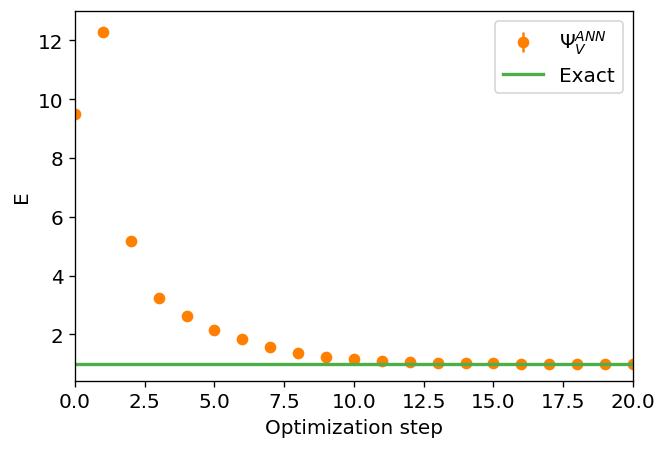

In [11]:
from matplotlib.pyplot import figure
palette = plt.get_cmap('Set1')
figure(num=None, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

step = jnp.asarray(steps_history)
energy = jnp.real(jnp.asarray(energy_history))
error = jnp.real(jnp.asarray(error_history))

p1 = plt.errorbar(step, energy, yerr=error, fmt='o', errorevery=1, markevery = 1, label = r'$\Psi_{V}^{ANN}$', zorder = 0, color = palette(4))
p2 = plt.axhline(y= 0.5 * npart * ndim, linestyle = '-', label = 'Exact', color = palette(2), lw = 2)

#plt.ylim(0.46,1)
plt.xlim(0,20)

plt.xlabel(r'Optimization step')
plt.ylabel('E')
plt.legend([p1, p2], [r'$\Psi_{V}^{ANN}$', r'Exact'], loc = 'upper right')
plt.savefig("ho_energies.pdf",bbox_inches = 'tight')
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


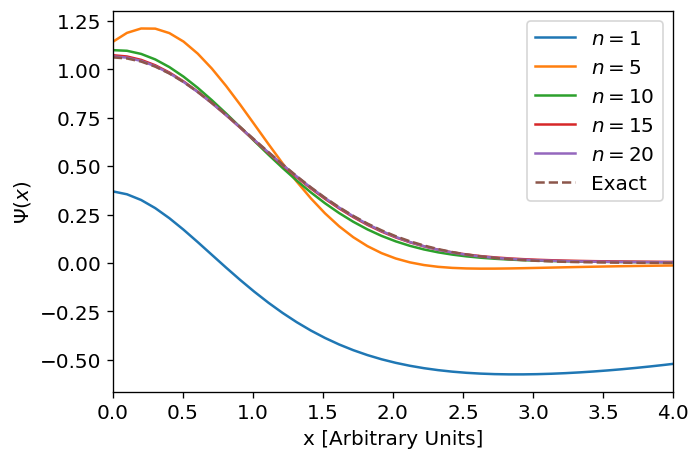

In [15]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# In the one-dimensional case, compare the learned and exact wave functions
x = jnp.linspace(0, 10, 100)

# Define and normalize the exact wave function (e.g., ground state of harmonic oscillator)
psi_exact = jnp.exp(-0.5 * x**2)
psi_exact /= jnp.sqrt(jnp.trapezoid(psi_exact**2, x))

# Evaluate and normalize the ANN wave functions over training checkpoints
psi_ann = []
for params in params_saved:
    psi = jnp.exp(jnp.asarray(wavefunction.vmap_logpsi(params, x)))
    psi /= jnp.sqrt(jnp.trapezoid(psi**2, x))
    psi_ann.append(psi)

# Plotting
figure(figsize=(6, 4), dpi=120)
plt.rcParams.update({'font.size': 12})
palette = plt.get_cmap('Set1')

# Select snapshots to visualize
snapshots = [0, 4, 9, 14, 19]
labels = [r'$n=1$', r'$n=5$', r'$n=10$', r'$n=15$', r'$n=20$']

for idx, label in zip(snapshots, labels):
    plt.plot(x, psi_ann[idx], '-', label=label)

plt.plot(x, psi_exact, '--', label='Exact')

plt.xlabel('x [Arbitrary Units]')
plt.ylabel(r'$\Psi(x)$')
plt.xlim(0, 4)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("ho_wavefunction.pdf", bbox_inches='tight')
plt.show()


In [16]:
# Set the parameters and instanciate the Wavefunction, Hamiltonian, and Metropolis classes
sig_i = 1.0         # Gaussian width for sampling the initial configuration
sig = 0.2           # Gaussian width for sampling the Metropolis Move
neq = 10            # Equilibration steps
nav = 10             # Averaging steps
nvoid = 100         # Void steps between energy calculations
nwalk = 400         # Quantum Monte Carlo configurations
ndim = 2            # Spatial dimension
npart = 3           # Number of particles
seed_walk = 19      # Seed to initialize the random-number generator of the Metropolis walk
seed_net = 17       # Seed to initialize the random-number generator of the neural network

key_net = random.PRNGKey(seed_net)
wavefunction = WavefunctionFermion(ndim, npart)
params, nparams = wavefunction.build(key_net)

hamiltonian = Hamiltonian(ndim, npart, wavefunction)
key_walk = random.PRNGKey(seed_walk)
metropolis = Metropolis(nwalk, npart, ndim, neq, nav, nvoid, sig, sig_i, wavefunction)
optimizer = Optimizer(ndim, npart, nparams, wavefunction)

In [17]:
steps_history = []
energy_history  = []
error_history = []
params_saved = []
for i in range (21):
    key_walk, key_input = jax.random.split(key_walk)
    #value, error, params = step_sgd(i, key_input, params)
    #value, error, params = step_adam(i, key_input, params)
    value, error, params = step_sr(i, key_input, params)
    print("step", i, "energy = ", value, "err=", error )
    steps_history.append(i)
    energy_history.append(value)
    error_history.append(error)
    params_saved.append(params)

step 0 energy =  (23.28944307975279+0.012540737536316321j) err= (0.1805595555632989-0.0003507218932508293j)
step 1 energy =  (13.89796118871445-0.00214865301239443j) err= (0.12194124931843175-0.0006255084693175307j)
step 2 energy =  (10.806728488871464-0.0069043069433858744j) err= (0.08084593458667305+0.00017324734680670582j)
step 3 energy =  (5.952200320719969+0.011713498322485272j) err= (0.0161835951182874+0.0006300007090242101j)
step 4 energy =  (5.575972656387652-0.007852840786292609j) err= (0.006190365029956701+0.0005138961789416299j)
step 5 energy =  (5.369633113154529+0.011755498480892903j) err= (0.0007976810225000967+0.003160914092664965j)
step 6 energy =  (5.242151989281065-0.0057006603127715124j) err= (1.8392698291244078e-06-0.002882817545433062j)
step 7 energy =  (5.168494926432117+0.0005406711139481284j) err= (0.0012698336373620335-0.000399676361751461j)
step 8 energy =  (5.1124284380567895+0.008737769989670784j) err= (1.9281888517422683e-05+0.0014915137570640127j)
step 9 e

In [18]:
import numpy as np
import math

def ground_state_energy_closed_shell(N, d):
    """
    Ground‐state energy for N spin-polarized fermions filling
    *closed* shells in a d-dimensional harmonic oscillator (m=ω=1).

    Parameters
    ----------
    N : int
        Total number of particles. Must satisfy N = C(nF + d, d) for some integer nF ≥ 0.
    d : int
        Number of spatial dimensions (d ≥ 1).

    Returns
    -------
    E0 : float
        Ground‐state energy E₀ = N * (d*nF/(d+1) + d/2).

    Raises
    ------
    ValueError
        If N does not correspond to a closed shell in dimension d.
    """
    # find the unique nF ≥ 0 such that binomial(nF + d, d) == N
    nF = 0
    while True:
        if math.comb(nF + d, d) == N:
            break
        if math.comb(nF + d, d) > N:
            raise ValueError(f"N={N} is not a closed shell for d={d}")
        nF += 1

    # compute the closed‐shell ground‐state energy
    E0 = N * (d * nF / (d + 1) + d / 2)
    return E0

# Example usage:
E0 = ground_state_energy_closed_shell(npart, ndim)
print('E0=', E0)

E0= 5.0


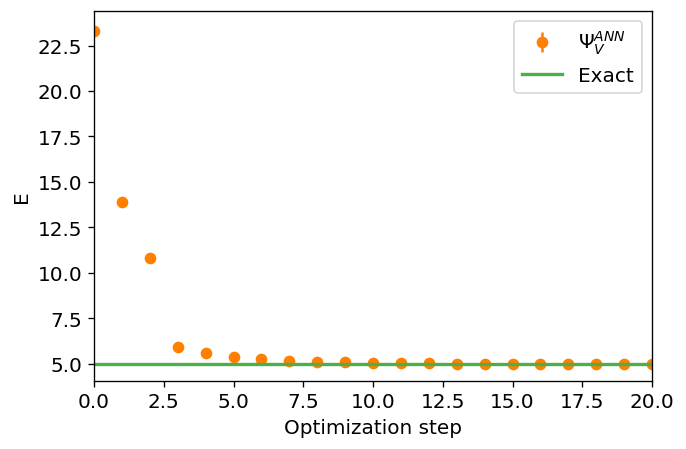

In [19]:
from matplotlib.pyplot import figure
palette = plt.get_cmap('Set1')
figure(num=None, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

E_exact = ground_state_energy_closed_shell(npart, ndim)

step = jnp.asarray(steps_history)
energy = jnp.real(jnp.asarray(energy_history))
error = jnp.real(jnp.asarray(error_history))

p1 = plt.errorbar(step, energy, yerr=error, fmt='o', errorevery=1, markevery = 1, label = r'$\Psi_{V}^{ANN}$', zorder = 0, color = palette(4))
p2 = plt.axhline(y= E_exact, linestyle = '-', label = 'Exact', color = palette(2), lw = 2)

#plt.ylim(0.46,1)
plt.xlim(0,20)

plt.xlabel(r'Optimization step')
plt.ylabel('E')
plt.legend([p1, p2], [r'$\Psi_{V}^{ANN}$', r'Exact'], loc = 'upper right')
plt.savefig("ho_energies.pdf",bbox_inches = 'tight')
plt.show()

E0= 2.0
